In [1]:
require 'nn'
require 'image'
local ParamBank = require 'ParamBank'


local SpatialConvolution = nn.SpatialConvolution
local SpatialConvolutionMM = nn.SpatialConvolutionMM
local SpatialMaxPooling = nn.SpatialMaxPooling

local cuda = false;

if cuda then
   require 'cunn'
   require 'cudnn'
   SpatialConvolution = cudnn.SpatialConvolution
   SpatialConvolutionMM = cudnn.SpatialConvolution
   SpatialMaxPooling = cudnn.SpatialMaxPooling
end

-- system parameters
local threads = 4
local offset  = 0

torch.setdefaulttensortype('torch.FloatTensor')
torch.setnumthreads(threads)
print('==> #threads:', torch.getnumthreads())


local function nilling(module)
   module.gradBias   = nil
   if module.finput then module.finput = torch.Tensor():typeAs(module.finput) end
   module.gradWeight = nil
   module.output     = torch.Tensor():typeAs(module.output)
   module.fgradInput = nil
   module.gradInput  = nil
end

local function netLighter(network)
   nilling(network)
   if network.modules then
      for _,a in ipairs(network.modules) do
         netLighter(a)
      end
   end
end


net = nn.Sequential()
local m = net.modules
if network == 'small' then
   print('==> init a small overfeat network')
   net:add(SpatialConvolution(3, 96, 11, 11, 4, 4))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(96, 256, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(1024, 3072, 6, 6, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(3072, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_0")
   ParamBank:read(        0, {96,3,11,11},    m[offset+1].weight)
   ParamBank:read(    34848, {96},            m[offset+1].bias)
   ParamBank:read(    34944, {256,96,5,5},    m[offset+4].weight)
   ParamBank:read(   649344, {256},           m[offset+4].bias)
   ParamBank:read(   649600, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  1829248, {512},           m[offset+8].bias)
   ParamBank:read(  1829760, {1024,512,3,3},  m[offset+11].weight)
   ParamBank:read(  6548352, {1024},          m[offset+11].bias)
   ParamBank:read(  6549376, {1024,1024,3,3}, m[offset+14].weight)
   ParamBank:read( 15986560, {1024},          m[offset+14].bias)
   ParamBank:read( 15987584, {3072,1024,6,6}, m[offset+17].weight)
   ParamBank:read(129233792, {3072},          m[offset+17].bias)
   ParamBank:read(129236864, {4096,3072,1,1}, m[offset+19].weight)
   ParamBank:read(141819776, {4096},          m[offset+19].bias)
   ParamBank:read(141823872, {1000,4096,1,1}, m[offset+21].weight)
   ParamBank:read(145919872, {1000},          m[offset+21].bias)

elseif network == 'big' then
   print('==> init a big overfeat network')
   net:add(SpatialConvolution(3, 96, 7, 7, 2, 2))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(96, 256, 7, 7, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(1024, 4096, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_1")
   ParamBank:read(        0, {96,3,7,7},      m[offset+1].weight)
   ParamBank:read(    14112, {96},            m[offset+1].bias)
   ParamBank:read(    14208, {256,96,7,7},    m[offset+4].weight)
   ParamBank:read(  1218432, {256},           m[offset+4].bias)
   ParamBank:read(  1218688, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  2398336, {512},           m[offset+8].bias)
   ParamBank:read(  2398848, {512,512,3,3},   m[offset+11].weight)
   ParamBank:read(  4758144, {512},           m[offset+11].bias)
   ParamBank:read(  4758656, {1024,512,3,3},  m[offset+14].weight)
   ParamBank:read(  9477248, {1024},          m[offset+14].bias)
   ParamBank:read(  9478272, {1024,1024,3,3}, m[offset+17].weight)
   ParamBank:read( 18915456, {1024},          m[offset+17].bias)
   ParamBank:read( 18916480, {4096,1024,5,5}, m[offset+20].weight)
   ParamBank:read(123774080, {4096},          m[offset+20].bias)
   ParamBank:read(123778176, {4096,4096,1,1}, m[offset+22].weight)
   ParamBank:read(140555392, {4096},          m[offset+22].bias)
   ParamBank:read(140559488, {1000,4096,1,1}, m[offset+24].weight)
   ParamBank:read(144655488, {1000},          m[offset+24].bias)

end
-- close file pointer
ParamBank:close()

==> #threads:	4	


In [5]:
-- OverFeat input arguements
local network  = 'small' or 'big'
local filename = 'bee.jpg'
local label     = require 'overfeat_label'

if cuda then net:cuda() end

-- load and preprocess image
print('==> prepare an input image')
local img_dim
if network == 'small' then    dim = 231
elseif network == 'big' then  dim = 221 end
local img_raw = image.load(filename):mul(255)
--local img_raw = image.lena():mul(255)
local rh = img_raw:size(2)
local rw = img_raw:size(3)
if rh < rw then
   rw = math.floor(rw / rh * dim)
   rh = dim
else
   rh = math.floor(rh / rw * dim)
   rw = dim
end
local img_scale = image.scale(img_raw, rw, rh)
local offsetx = 1
local offsety = 1
if rh < rw then
   offsetx = offsetx + math.floor((rw-dim)/2)
else
   offsety = offsety + math.floor((rh-dim)/2)
end
img = img_scale[{{},{offsety,offsety+dim-1},{offsetx,offsetx+dim-1}}]:floor()


-- feedforward network
print('==> feed the input image')
timer = torch.Timer()
img:add(-118.380948):div(61.896913)  -- fixed distn ~ N(118.380948, 61.896913^2)
if cuda then 
   img = img:cuda():view(1, img:size(1), img:size(2), img:size(3))
   local out = net:forward(img):clone():float()
   prob, idx = torch.max(out[1], 1)
else
   prob, idx = torch.max(net:forward(img), 1)
end
print(idx)
--print(label[idx:squeeze()], prob:squeeze())
--print('Time elapsed: ' .. timer:time().real .. ' seconds')

==> prepare an input image	
==> feed the input image	
(1,.,.) = 
 Columns 1 to 26
  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1 

 2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 

 2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  1  1  1  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2 

 2  2  2  2  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  1  1  1  1  1  1  1  1  1  2  2  1  1  2  1  1  1  1  1  1  1  1  1
  2  1  1  2  1  2  2  1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1  1  2  2
  2  1  2  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  1  1  1  1  1  1  2  2
  2  2  2  2  2  2  2  2  2  2  2  1  1  2  2  2  2  1  1  1  1  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  1  1  2  2  2  2  1  1  1  1  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  1  2  2  2  2  1  1  1  2  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  2  2  2  2  2  2  2  2  1
  2  2  2  2 

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 

1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  2  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  2  1  1  2  1  1  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  2  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  1  1  1  1  2  2  2  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  1  1  1  2  2  2  2  2  2  2  2  

2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  

1  1  1  1  1  1  1  1  1
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  

1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  2  2  2  2  2  2  1  1  1  1  1  1  1  1
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  2  2  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  1  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  

1  2  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  1  2  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1
  1  2  2  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1


  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

  1  1  1  1
  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1

  1  1  1  1  1  1  1  1
  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  2  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  1  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1

  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1


  2  2  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  2  2
  2  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2
  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2

  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1

  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2
  1  1  1  1  1  1  1  1  1

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

 2  2  2  2  2  2  2  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  1  1  2  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2  2  2  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  1  1  1  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  1  1  1  1  1  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  

1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  

2  2  2  2  2  2  2  2  2
  1  1  1  1  2  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  2  2  2  2  2  2  

  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1 

  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2
  2  2  2  2  1  1  1  1  1  1  1  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  2  2  2  2  2  1  1  1  2  1  1  1  1  2  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  1  1  1  2  3  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 

 1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

 2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 

1  1  1  1  1  2  1  1  1  1  1  2  2  1  1  1
  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  1  1  2  1  2  1  1  1  1  1  1  1  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  3  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  3  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1
  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

2  2  2  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  1  1  2  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  2  1  1  1  1  1  1  1  1  2  1
  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1
  2  2  2  2  1  2  2  2  2  2  2  2  1  1  1  1  1  1  2  1  1  1  1  1  1  1
  2  2  2  2  1  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  2  2  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  2

  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

Columns 183 to 208
  1  1  1  1  1 

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  2  2  2  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  1  1  2  2  2  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  1  1  1  1  1  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  1  1  1  2  2  1  1  1  1  2  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  1  1  1  1  1  1  1  1  1  1  2  1  1  1  

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  

 1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1

  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  2  2  1  1  

  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  1  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  1  2  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  

1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2 

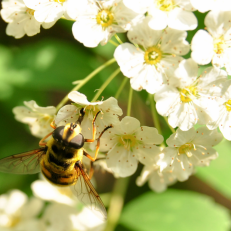

In [6]:
itorch.image(img)

In [23]:
output = net:forward(img)
confidence, index = output:float():sort()

In [24]:
print("predicted class: " .. index[1] .. " with confidence: " .. confidence[1])


[string "print("predicted class: " .. index[1] .. " wi..."]:1: (null) has no concat operator
stack traceback:
	[C]: in function '__concat'
	[string "print("predicted class: " .. index[1] .. " wi..."]:1: in main chunk
	[C]: in function 'xpcall'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:177: in function </opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:143>
	/opt/boxen/homebrew/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/fcarey/.ipython/profile_default/..."]:1: in main chunk: 

In [16]:
itorch.image(tmpimg)

/opt/boxen/homebrew/share/lua/5.1/image/init.lua:822: attempt to index a nil value
stack traceback:
	/opt/boxen/homebrew/share/lua/5.1/image/init.lua:822: in function 'toDisplayTensor'
	/opt/boxen/homebrew/share/lua/5.1/itorch/gfx.lua:20: in function 'f'
	[string "local f = function() return itorch.image(tmpi..."]:1: in main chunk
	[C]: in function 'xpcall'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:177: in function </opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:143>
	/opt/boxen/homebrew/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/fcarey/.ipython/profile_default/..."]:1: in main chunk: 